In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense,SimpleRNN
from sklearn.metrics import mean_absolute_error, mean_squared_error,r2_score
from math import sqrt
import xgboost as xgb

D:\Python\Anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# 读取传感器数据
data = pd.read_csv("training_dataset.csv",sep=";")
print(data.columns)
data['Date'] = pd.to_datetime(data['Date'], format='%Y%m%d')
data['Time'] = pd.to_datetime(data['Time'], format='%H:%M:%S').dt.time
data.info()

Index(['DP_ID', 'PORTAL', 'Date', 'Time', 'Interval_1', 'Interval_5',
       'Interval_15', 'Interval_30', 'Interval_60', 'SPEED_MS_AVG', 'FLOW'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1921967 entries, 0 to 1921966
Data columns (total 11 columns):
 #   Column        Dtype         
---  ------        -----         
 0   DP_ID         int64         
 1   PORTAL        object        
 2   Date          datetime64[ns]
 3   Time          object        
 4   Interval_1    int64         
 5   Interval_5    int64         
 6   Interval_15   int64         
 7   Interval_30   int64         
 8   Interval_60   int64         
 9   SPEED_MS_AVG  float64       
 10  FLOW          float64       
dtypes: datetime64[ns](1), float64(2), int64(6), object(2)
memory usage: 161.3+ MB


In [3]:
# 数据预处理
# 合并日期和时间列为时间戳
data['Timestamp'] = data.apply(lambda row: pd.datetime.combine(row['Date'], row['Time']), axis=1)
# 确保数据按时间排序
data = data.sort_values(by='Timestamp')
clean_data = data.dropna(subset=['FLOW'])
clean_traffic_data = data.dropna(subset=['FLOW'])
# 选择车流量特征
traffic_data = clean_traffic_data[['Timestamp', 'FLOW']]

C:\Users\stein\AppData\Local\Temp\ipykernel_11916\900628363.py:3: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  data['Timestamp'] = data.apply(lambda row: pd.datetime.combine(row['Date'], row['Time']), axis=1)


In [16]:
data.head(10)

,DP_ID,PORTAL,Date,Time,Interval_1,Interval_5,Interval_15,Interval_30,Interval_60,SPEED_MS_AVG,FLOW,Timestamp
0,543,"E4S 56,780",2021-06-01,04:00:00,240,48,16,8,4,19.34,10.0,2021-06-01 04:00:00
23,1079,"E4S 56,780",2021-06-01,04:00:00,240,48,16,8,4,21.10,11.0,2021-06-01 04:00:00
22,1076,"E4S 55,620",2021-06-01,04:00:00,240,48,16,8,4,20.27,6.0,2021-06-01 04:00:00
21,1254,"E4S 55,620",2021-06-01,04:00:00,240,48,16,8,4,24.53,4.0,2021-06-01 04:00:00
20,902,"E4S 56,490",2021-06-01,04:00:00,240,48,16,8,4,22.92,15.0,2021-06-01 04:00:00
19,749,"E4S 57,055",2021-06-01,04:00:00,240,48,16,8,4,21.45,12.0,2021-06-01 04:00:00
18,740,"E4S 56,160",2021-06-01,04:00:00,240,48,16,8,4,21.99,17.0,2021-06-01 04:00:00
16,4473,"E4S 58,140",2021-06-01,04:00:00,240,48,16,8,4,20.83,1.0,2021-06-01 04:00:00
15,4428,"E4S 57,820",2021-06-01,04:00:00,240,48,16,8,4,19.72,2.0,2021-06-01 04:00:00
14,1443,"E4S 57,055",2021-06-01,04:00:00,240,48,16,8,4,22.41,8.0,2021-06-01 04:00:00


In [42]:
clean_data.sort_values(by='FLOW', ascending=True)

,DP_ID,PORTAL,Date,Time,Interval_1,Interval_5,Interval_15,Interval_30,Interval_60,SPEED_MS_AVG,FLOW,Timestamp
215571,4439,"E4S 57,820",2021-06-23,05:41:00,341,68,22,11,5,31.94,1.0,2021-06-23 05:41:00
1623202,4472,"E4S 58,140",2021-11-28,07:43:00,463,92,30,15,7,24.17,1.0,2021-11-28 07:43:00
1250840,4494,"E4S 58,140",2021-10-18,04:21:00,261,52,17,8,4,20.56,1.0,2021-10-18 04:21:00
1492704,4872,"E4S 56,780",2021-11-13,08:09:00,489,97,32,16,8,15.83,1.0,2021-11-13 08:09:00
1492741,4496,"E4S 58,140",2021-11-13,08:10:00,490,98,32,16,8,15.28,1.0,2021-11-13 08:10:00
...,...,...,...,...,...,...,...,...,...,...,...,...
1524655,153,"E4S 56,490",2021-11-17,05:29:00,329,65,21,10,5,22.13,42.0,2021-11-17 05:29:00
1515456,153,"E4S 56,490",2021-11-16,05:27:00,327,65,21,10,5,16.33,43.0,2021-11-16 05:27:00
745926,4429,"E4S 57,435",2021-08-23,07:48:00,468,93,31,15,7,20.00,43.0,2021-08-23 07:48:00
6540,4429,"E4S 57,435",2021-06-01,08:05:00,485,97,32,16,8,20.83,44.0,2021-06-01 08:05:00


In [17]:
print(clean_data.isnull().sum())
print(traffic_data.isnull().sum())

DP_ID           0
PORTAL          0
Date            0
Time            0
Interval_1      0
Interval_5      0
Interval_15     0
Interval_30     0
Interval_60     0
SPEED_MS_AVG    0
FLOW            0
Timestamp       0
dtype: int64
Timestamp    0
FLOW         0
dtype: int64


In [4]:
def create_time_windows(clean_data, window_size):
    X, y = [], []
    for i in range(len(clean_data) - window_size):
        X.append(clean_data['FLOW'].values[i:i+window_size])
        y.append(clean_data['FLOW'].values[i+window_size])
    return np.array(X), np.array(y)

window_size = [5,15,30,60]  # 15分钟的时间窗口
X, y = create_time_windows(traffic_data, window_size[1])


In [6]:
# Split train and test
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=False)


In [8]:
# Normalization
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)


LSTM

In [21]:
# 创建并训练LSTM模型
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(window_size[1], 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(X_train_scaled, y_train, epochs=10, batch_size=32, validation_data=(X_val_scaled, y_val))

# # 创建并训练RNN模型
# rnn_model = Sequential()
# rnn_model.add(SimpleRNN(50, activation='relu', input_shape=(window_size, 1)))
# rnn_model.add(Dense(1))
# rnn_model.compile(optimizer='adam', loss='mean_squared_error')

# rnn_model.fit(X_train_scaled, y_train, epochs=10, batch_size=32, validation_data=(X_val_scaled, y_val))
# rnn_y_pred = rnn_model.predict(X_val_scaled)

Epoch 1/10
48048/48048 [==============================] - 400s 8ms/step - loss: 42.6715 - val_loss: 31.7460
Epoch 2/10
48048/48048 [==============================] - 394s 8ms/step - loss: 41.4675 - val_loss: 32.0343
Epoch 3/10
48048/48048 [==============================] - 400s 8ms/step - loss: 41.1721 - val_loss: 31.6277
Epoch 4/10
48048/48048 [==============================] - 397s 8ms/step - loss: 40.9585 - val_loss: 31.4779
Epoch 5/10
48048/48048 [==============================] - 458s 10ms/step - loss: 40.7768 - val_loss: 31.4236
Epoch 6/10
48048/48048 [==============================] - 472s 10ms/step - loss: 40.6372 - val_loss: 31.2648
Epoch 7/10
48048/48048 [==============================] - 404s 8ms/step - loss: 40.5376 - val_loss: 31.4740
Epoch 8/10
48048/48048 [==============================] - 407s 8ms/step - loss: 40.4377 - val_loss: 31.1121
Epoch 9/10
48048/48048 [==============================] - 403s 8ms/step - loss: 40.3671 - val_loss: 31.2876
Epoch 10/10
48048/48048 [=

In [27]:
y_pred = model.predict(X_val_scaled)

rmse = sqrt(mean_squared_error(y_val, y_pred))
mae = mean_absolute_error(y_val, y_pred)

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")


12012/12012 [==============================] - 48s 4ms/step
RMSE: 5.5724013064826465
MAE: 4.28310814118931


In [30]:
r2 = r2_score(y_val, y_pred)

# 计算调整R方
n = len(y_val)  # 样本数量
p = X_val_scaled.shape[1]  # 自变量数量（特征数量）
adjusted_r2 = 1 - (1 - r2) * ((n - 1) / (n - p - 1))

print("(R-squared):", r2)
print(" (Adjusted R-squared):", adjusted_r2)

(R-squared): 0.4818646538881748
 (Adjusted R-squared): 0.48184443328834525


In [23]:
# 检查输入数据中的NaN值
print(np.isnan(X_val_scaled).sum())
# 检查目标数据中的NaN值
print(np.isnan(y_val).sum())
print(np.isnan(y_pred).sum())

0
0
0


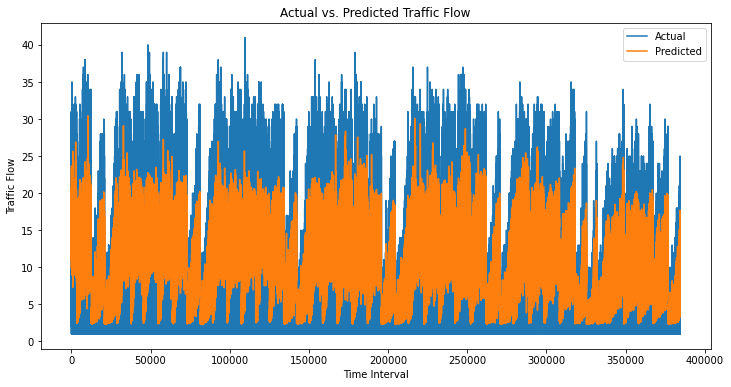

In [44]:
# 可视化结果
plt.figure(figsize=(12, 6))
plt.plot(y_val, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.title('Actual vs. Predicted Traffic Flow')
plt.xlabel('Time Interval')
plt.ylabel('Traffic Flow')
plt.show()

12012/12012 [==============================] - 51s 4ms/step


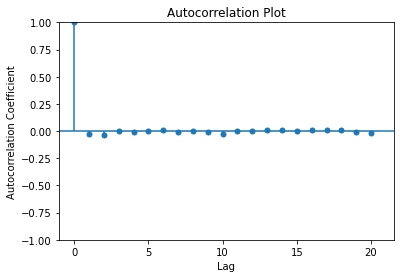

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

# 计算验证集上的残差
y_val_pred = model.predict(X_val_scaled)  # 使用模型预测
residuals = y_val - y_val_pred.flatten()  # 计算残差


# 绘制自相关图
plot_acf(residuals, lags=20)  # 设置lags参数来指定自相关图的滞后阶数
plt.title('Autocorrelation Plot')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation Coefficient')
plt.show()

RNN

In [45]:
# 创建并训练RNN模型
rnn_model = Sequential()
rnn_model.add(SimpleRNN(50, activation='relu', input_shape=(window_size[1], 1)))
rnn_model.add(Dense(1))
rnn_model.compile(optimizer='adam', loss='mean_squared_error')

rnn_model.fit(X_train_scaled, y_train, epochs=10, batch_size=32, validation_data=(X_val_scaled, y_val))
rnn_y_pred = rnn_model.predict(X_val_scaled)

Epoch 1/10
48048/48048 [==============================] - 211s 4ms/step - loss: 42.7983 - val_loss: 31.9587
Epoch 2/10
48048/48048 [==============================] - 210s 4ms/step - loss: 41.7784 - val_loss: 31.7489
Epoch 3/10
48048/48048 [==============================] - 218s 5ms/step - loss: 41.5955 - val_loss: 32.0135
Epoch 4/10
48048/48048 [==============================] - 216s 4ms/step - loss: 41.4891 - val_loss: 31.8005
Epoch 5/10
48048/48048 [==============================] - 215s 4ms/step - loss: 41.3920 - val_loss: 31.6568
Epoch 6/10
48048/48048 [==============================] - 210s 4ms/step - loss: 41.3060 - val_loss: 31.6152
Epoch 7/10
48048/48048 [==============================] - 205s 4ms/step - loss: 41.2274 - val_loss: 31.6770
Epoch 8/10
48048/48048 [==============================] - 209s 4ms/step - loss: 41.1804 - val_loss: 31.6394
Epoch 9/10
48048/48048 [==============================] - 205s 4ms/step - loss: 41.1590 - val_loss: 31.5197
Epoch 10/10
12012/12012 [===

In [46]:
rnn_rmse = sqrt(mean_squared_error(y_val, rnn_y_pred))
rnn_mae = mean_absolute_error(y_val, rnn_y_pred)

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")

RMSE: 5.5724013064826465
MAE: 4.28310814118931


In [47]:
r2 = r2_score(y_val, rnn_y_pred)

# 计算调整R方
n = len(y_val)  # 样本数量
p = X_val_scaled.shape[1]  # 自变量数量（特征数量）
adjusted_r2 = 1 - (1 - r2) * ((n - 1) / (n - p - 1))

print("(R-squared):", r2)
print(" (Adjusted R-squared):", adjusted_r2)

(R-squared): 0.47534070264831574
 (Adjusted R-squared): 0.47532022744665614


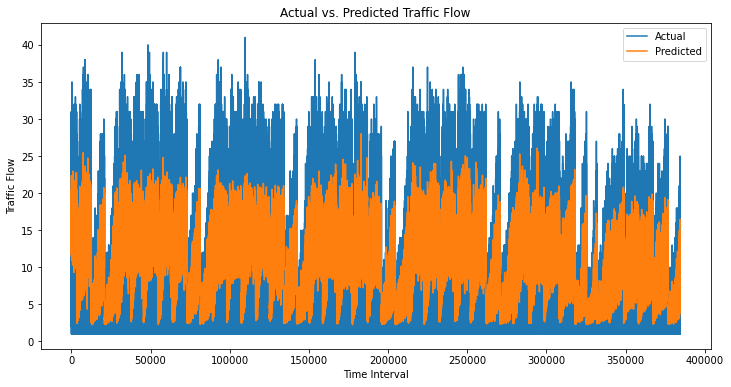

In [48]:
# 可视化结果
plt.figure(figsize=(12, 6))
plt.plot(y_val, label='Actual')
plt.plot(rnn_y_pred, label='Predicted')
plt.legend()
plt.title('Actual vs. Predicted Traffic Flow')
plt.xlabel('Time Interval')
plt.ylabel('Traffic Flow')
plt.show()

12012/12012 [==============================] - 31s 3ms/step


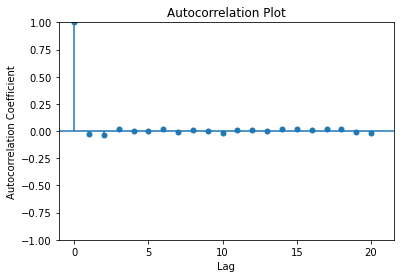

In [49]:
# 计算验证集上的残差
rnn_y_val_pred = rnn_model.predict(X_val_scaled)  # 使用模型预测
residuals = y_val - rnn_y_val_pred.flatten()  # 计算残差


# 绘制自相关图
plot_acf(residuals, lags=20)  # 设置lags参数来指定自相关图的滞后阶数
plt.title('Autocorrelation Plot')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation Coefficient')
plt.show()

预测结果: [13.27349   14.375598  17.151009  ...  5.0915403  6.422582   6.883534 ]


D:\Python\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 23454 (\N{CJK UNIFIED IDEOGRAPH-5B9E}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
D:\Python\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 38469 (\N{CJK UNIFIED IDEOGRAPH-9645}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
D:\Python\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 20540 (\N{CJK UNIFIED IDEOGRAPH-503C}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
D:\Python\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 39044 (\N{CJK UNIFIED IDEOGRAPH-9884}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
D:\Python\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 27979 (\N{CJK UNIFIED IDEOGRAPH-6D4B}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
D:\Python\Anaco

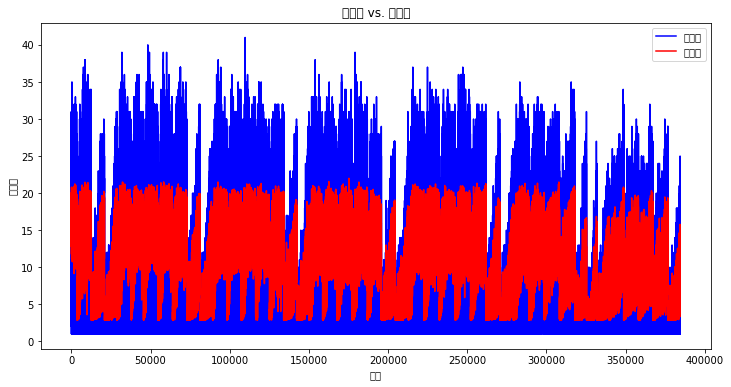

In [10]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5]
}

xgb_model = xgb.XGBRegressor()
# grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error')
# grid_search.fit(X_train_scaled, y_train)

# best_params = grid_search.best_params_
# print("Best super_params:", best_params)

# # 使用最佳超参数创建并训练XGBoost模型
# best_xgb_model = xgb.XGBRegressor(**best_params)
# best_xgb_model.fit(X_train_scaled, y_train)
xgb_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=3)
xgb_model.fit(X_train_scaled, y_train)
# 预测
xgb_y_pred = xgb_model.predict(X_val_scaled)

# 输出预测结果
print("pred_result:", xgb_y_pred)

# 可视化预测结果
plt.figure(figsize=(12, 6))
plt.plot(y_val, label='Actual', color='blue')
plt.plot(xgb_y_pred, label='Predict', color='red')
plt.title('Actual vs.Predict')
plt.xlabel('Time interval')
plt.ylabel('Flow')
plt.legend()
plt.show()

pred_result: [13.27349   14.375598  17.151009  ...  5.0915403  6.422582   6.883534 ]


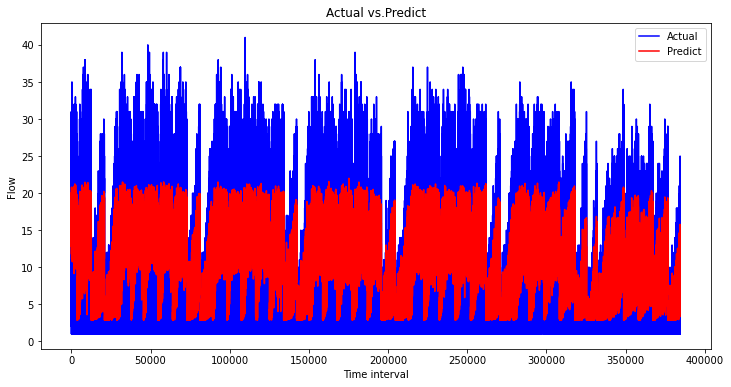

In [11]:
print("pred_result:", xgb_y_pred)

# 可视化预测结果
plt.figure(figsize=(12, 6))
plt.plot(y_val, label='Actual', color='blue')
plt.plot(xgb_y_pred, label='Predict', color='red')
plt.title('Actual vs.Predict')
plt.xlabel('Time interval')
plt.ylabel('Flow')
plt.legend()
plt.show()

In [12]:
r2 = r2_score(y_val, xgb_y_pred)

# 计算调整R方
n = len(y_val)  # 样本数量
p = X_val_scaled.shape[1]  # 自变量数量（特征数量）
adjusted_r2 = 1 - (1 - r2) * ((n - 1) / (n - p - 1))

print("(R-squared):", r2)
print(" (Adjusted R-squared):", adjusted_r2)

(R-squared): 0.46863043276138616
 (Adjusted R-squared): 0.468609695686679


In [15]:
new_data = clean_data[['DP_ID', 'Date','Time', 'FLOW']]

# 添加Month列，提取日期中的月份信息
new_data['Date'] = pd.to_datetime(new_data['Date'], format='%Y%m%d')
new_data['Month'] = new_data['Date'].dt.month

# 添加Week_num列，提取日期中的周数信息
new_data['Week_num'] = new_data['Date'].dt.week

# 添加past_5mins_avg列，计算过去五分钟的流量平均值
new_data['past_5mins_avg'] = new_data['FLOW'].rolling(window=5).mean()

# 添加past_1week_sameday&time列，计算过去一周相同日期和时间的流量平均值
new_data['past_1week_sameday&time'] = new_data.groupby(['DP_ID', 'Date', 'Time'])['FLOW'].transform('mean')

# 打印新的DataFrame
print(new_data)


C:\Users\stein\AppData\Local\Temp\ipykernel_11916\1230274383.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_data['Date'] = pd.to_datetime(new_data['Date'], format='%Y%m%d')
C:\Users\stein\AppData\Local\Temp\ipykernel_11916\1230274383.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_data['Month'] = new_data['Date'].dt.month
C:\Users\stein\AppData\Local\Temp\ipykernel_11916\1230274383.py:8: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocal

         DP_ID       Date      Time  FLOW  Month  Week_num  past_5mins_avg  \
0          543 2021-06-01  04:00:00  10.0      6        22             NaN   
23        1079 2021-06-01  04:00:00  11.0      6        22             NaN   
22        1076 2021-06-01  04:00:00   6.0      6        22             NaN   
21        1254 2021-06-01  04:00:00   4.0      6        22             NaN   
20         902 2021-06-01  04:00:00  15.0      6        22             9.2   
...        ...        ...       ...   ...    ...       ...             ...   
1921941   4873 2021-12-31  10:00:00   4.0     12        52             3.6   
1921940   1443 2021-12-31  10:00:00   6.0     12        52             2.6   
1921965    351 2021-12-31  10:00:00   9.0     12        52             4.2   
1921952   4473 2021-12-31  10:00:00   7.0     12        52             5.4   
1921966    534 2021-12-31  10:00:00   6.0     12        52             6.4   

         past_1week_sameday&time  
0                           

C:\Users\stein\AppData\Local\Temp\ipykernel_11916\1230274383.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_data['past_1week_sameday&time'] = new_data.groupby(['DP_ID', 'Date', 'Time'])['FLOW'].transform('mean')
